# 21.1 Mean–Variance Portfolio Optimization
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**:

Introduces the foundational framework of modern portfolio theory through the classical Markowitz mean–variance optimization problem. The objective is to:
- formalize portfolio allocation as a convex optimization problem,
- estimate expected returns and covariance from market data,
- construct the efficient frontier,
- identify key portfolios (minimum variance, tangency),
- critically discuss the practical limitations of mean–variance optimization.

**This notebook**: 

Serves as the conceptual baseline for all subsequent portfolio construction methods.


# 0. Imports

We work with a diversified set of liquid ETFs:
- SPY (US equities)
- QQQ (US growth / tech)
- TLT (long-duration bonds)
- GLD (gold)
- EFA (developed ex-US equities)
- EEM (emerging markets equities)
- HYG (high-yield credit)

ETFs are used for their liquidity, diversification, and clean economic interpretation. We work with monthly returns rather than daily data:
- reduced microstructure noise,
- more stable estimates,
- closer to the assumptions of classical portfolio theory.

A central theme of this notebook is estimation error, especially in expected returns.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True
sns.set_style("whitegrid")

In [6]:
tickers = ["SPY", "QQQ", "TLT", "GLD", "EFA", "EEM", "HYG"]
start_date = "2010-01-01"

prices = yf.download(tickers, start=start_date, progress=False)["Close"]
prices = prices.dropna()
prices.head()

Ticker,EEM,EFA,GLD,HYG,QQQ,SPY,TLT
Date,,,,,,,
2010-01-04,30.785862,35.764996,109.800003,35.435665,40.393574,85.279213,56.984077
2010-01-05,31.009308,35.796505,109.699997,35.603783,40.393574,85.504936,57.352104
2010-01-06,31.074190,35.947811,111.510002,35.695854,40.149929,85.565155,56.584354
2010-01-07,30.893980,35.809116,110.820000,35.839958,40.176041,85.926361,56.679558
2010-01-08,31.139053,36.092812,111.370003,35.895996,40.506672,86.212296,56.654152


We resample prices to monthly frequency and compute log-returns.

In [7]:
prices_m = prices.resample("M").last()
returns_m = np.log(prices_m / prices_m.shift(1)).dropna()

returns_m.head()

Ticker,EEM,EFA,GLD,HYG,QQQ,SPY,TLT
Date,,,,,,,
2010-02-28,0.017608,0.002664,0.032223,0.018560,0.045010,0.030718,-0.003430
2010-03-31,0.077987,0.061898,-0.004396,0.021111,0.074281,0.059099,-0.020789
2010-04-30,-0.001663,-0.028446,0.057169,0.019062,0.022178,0.015351,0.032679
2010-05-31,-0.098645,-0.118702,0.030057,-0.047884,-0.076799,-0.082788,0.049822
2010-06-30,-0.014085,-0.020835,0.023280,0.011050,-0.061617,-0.053128,0.056360


**Exploratory plots**

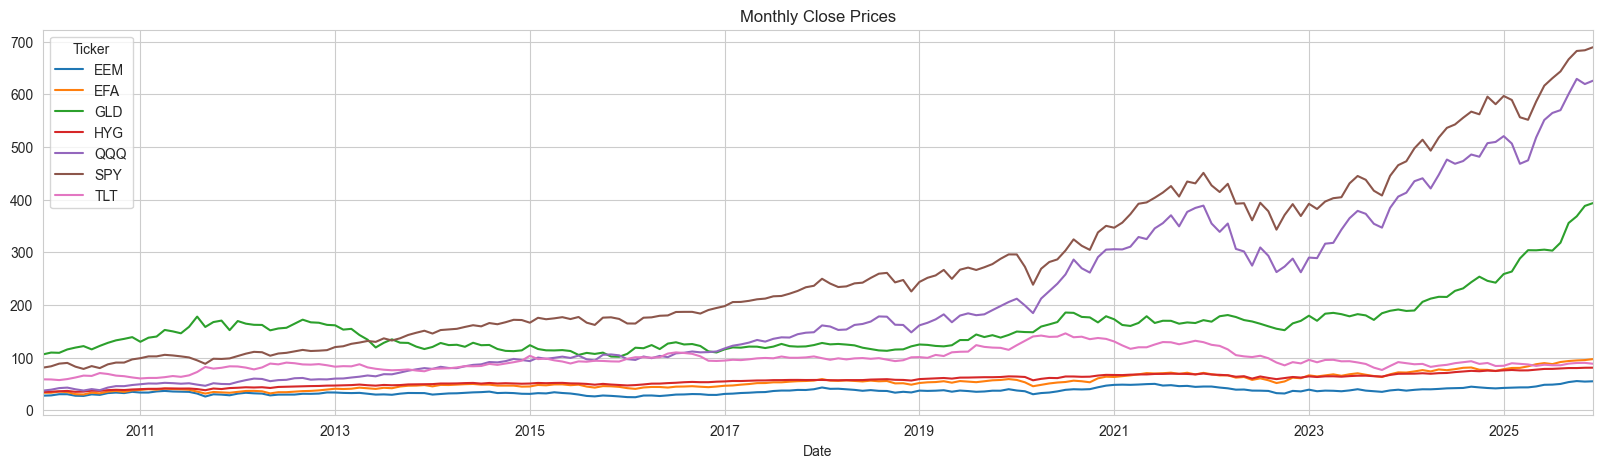

In [11]:
prices_m.plot(title="Monthly Close Prices", figsize=(20, 5) )
plt.show()

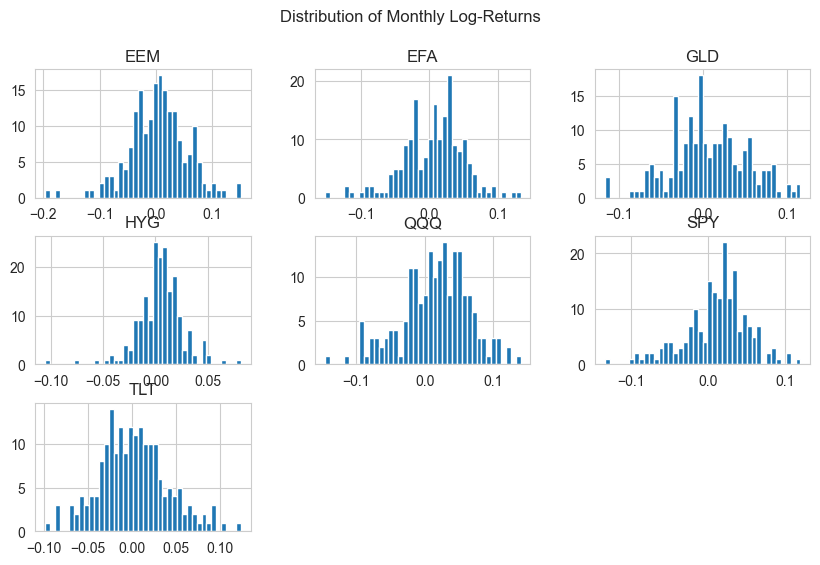

In [9]:
returns_m.hist(bins=40, figsize=(10, 6))
plt.suptitle("Distribution of Monthly Log-Returns")
plt.show()

- Monthly return distributions differ widely across assets, reflecting very heterogeneous volatility and tail risk profiles.
- Equities (SPY, QQQ, EEM, EFA) exhibit higher dispersion and fatter tails than bonds (TLT) and gold (GLD).
- Bonds and gold show more stable dynamics and distinct behavior during stress periods, clearly separating them from equities.
- This cross-asset heterogeneity provides the structural basis for diversification, as different assets respond differently to market regimes and shocks.

### 

# 1. Estimation of Inputs ($\mu$, $\Sigma$)

Mean–variance optimization relies on two inputs:

**Expected returns vector:**

$$\mu = \mathbb{E}[R]$$

**Covariance matrix:**

$$\Sigma = \mathbb{E}[(R-\mu)(R-\mu)^\top]$$

In practice, both quantities must be estimated from data.

**difficulty:**
- expected returns are extremely noisy,
- covariances are relatively more stable.


In [12]:
mu = returns_m.mean().values
Sigma = returns_m.cov().values

mu, Sigma.shape

(array([0.0036    , 0.00563202, 0.00686575, 0.00444812, 0.01477191,
        0.01122196, 0.00214275]),
 (7, 7))

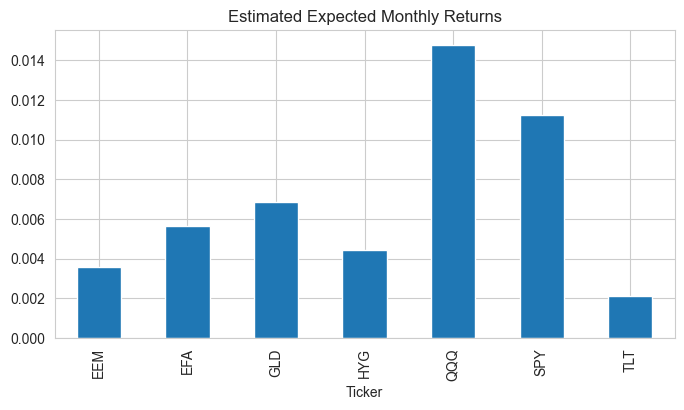

In [14]:
pd.Series(mu, index=returns_m.columns).plot(
    kind="bar",
    title="Estimated Expected Monthly Returns"
)
plt.show()

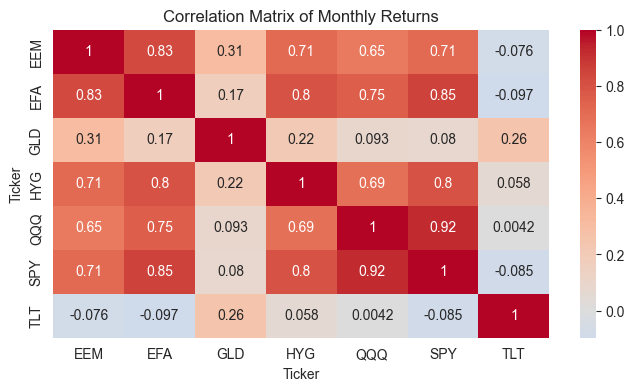

In [15]:
sns.heatmap(
    returns_m.corr(),
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Matrix of Monthly Returns")
plt.show()

- Estimated expected monthly returns are small, noisy, and highly unstable, making them difficult to estimate reliably.
- Equity assets (QQQ, SPY) show higher average returns, while bonds (TLT) and gold (GLD) exhibit lower but more defensive profiles.
- The correlation matrix reveals strong equity clustering and low or negative correlation with bonds and gold, creating meaningful diversification potential.
- In portfolio optimization, results will be far more sensitive to the choice of expected returns (μ) than to the covariance matrix (Σ), reinforcing the need for robust return estimation or shrinkage techniques.

# 2. The Markowitz Optimization Problem

We now formalize portfolio construction as a convex optimization problem.

For a target return $\mu^*$, we solve:

$$\min_{w} \; w^\top \Sigma w$$

subject to:

$$
\begin{align}
w^\top \mu &= \mu^* \\
\sum_{i} w_i &= 1 \\
w_i &\geq 0
\end{align}
$$

- Variance measures risk.
- Constraints enforce full investment and long-only portfolios.
- The problem is convex → global optimum.

# 3. Efficient Frontier

We solve the optimization problem for a grid of target returns and store the resulting portfolio risk.


In [16]:
n_assets = len(mu)
w = cp.Variable(n_assets)

Sigma_cp = cp.Parameter((n_assets, n_assets), PSD=True)
mu_cp = cp.Parameter(n_assets)

Sigma_cp.value = Sigma
mu_cp.value = mu

In [17]:
target_returns = np.linspace(mu.min(), mu.max(), 40)
frontier_vol = []
frontier_ret = []

for mu_target in target_returns:
    prob = cp.Problem(
        cp.Minimize(cp.quad_form(w, Sigma_cp)),
        [
            w @ mu_cp == mu_target,
            cp.sum(w) == 1,
            w >= 0
        ]
    )
    prob.solve()
    
    frontier_vol.append(np.sqrt(w.value.T @ Sigma @ w.value))
    frontier_ret.append(mu_target)

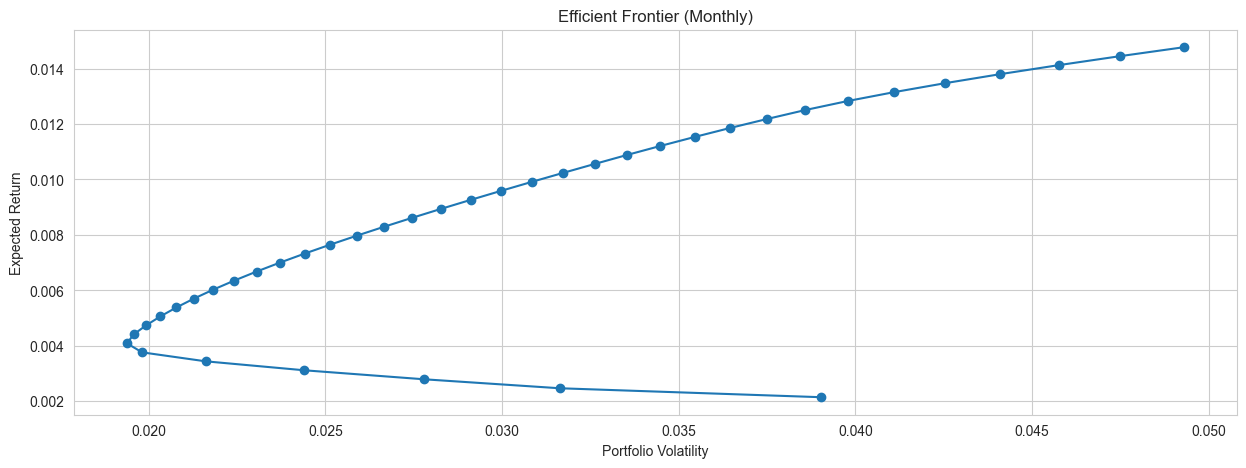

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(frontier_vol, frontier_ret, marker="o")
plt.xlabel("Portfolio Volatility")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier (Monthly)")
plt.show()

- The efficient frontier captures the risk–return trade-off.
- Diversification initially reduces risk strongly.
- Marginal gains in return become costly in risk.

# 4. Core Portfolios
## Minimum Variance Portfolio

In [24]:
w_minvar = cp.Variable(n_assets)

prob_minvar = cp.Problem(
    cp.Minimize(cp.quad_form(w_minvar, Sigma_cp)),
    [
        cp.sum(w_minvar) == 1,
        w_minvar >= 0
    ]
)
prob_minvar.solve()

w_minvar = pd.Series(w_minvar.value, index=returns_m.columns)
w_minvar

Ticker
EEM   -1.518536e-19
EFA   -1.764461e-19
GLD    6.215599e-02
HYG    7.336855e-01
QQQ   -1.659701e-19
SPY   -1.777100e-19
TLT    2.041585e-01
dtype: float64

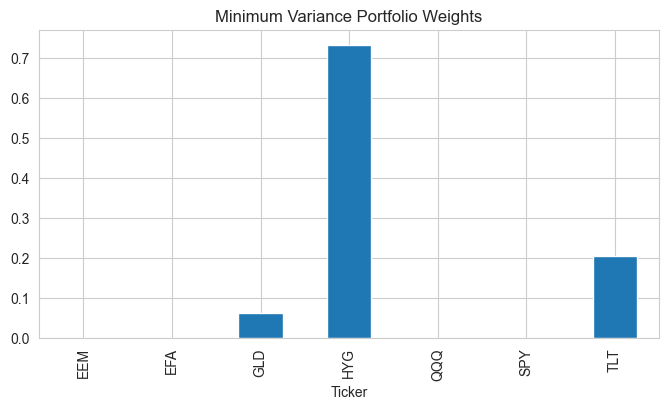

In [28]:
w_minvar.plot(kind="bar", title="Minimum Variance Portfolio Weights")
plt.show()

## Tangency Portfolio (Maximum Sharpe, rf = 0)

The Sharpe ratio is:

$$\text{Sharpe}(w) = \frac{w^\top \mu}{\sqrt{w^\top \Sigma w}}$$

Maximizing Sharpe is equivalent to:

$$\max_{w} \; w^\top \mu$$

subject to:

$$w^\top \Sigma w = 1$$


In [29]:
w_tan = cp.Variable(n_assets)

prob_tan = cp.Problem(
    cp.Maximize(w_tan @ mu_cp),
    [
        cp.quad_form(w_tan, Sigma_cp) <= 1,
        w_tan >= 0
    ]
)
prob_tan.solve()

w_tan = pd.Series(w_tan.value / w_tan.value.sum(), index=returns_m.columns)
w_tan

Ticker
EEM    5.757442e-10
EFA    9.222772e-10
GLD    2.908348e-01
HYG    8.960326e-09
QQQ    6.438929e-01
SPY    7.687699e-08
TLT    6.527214e-02
dtype: float64

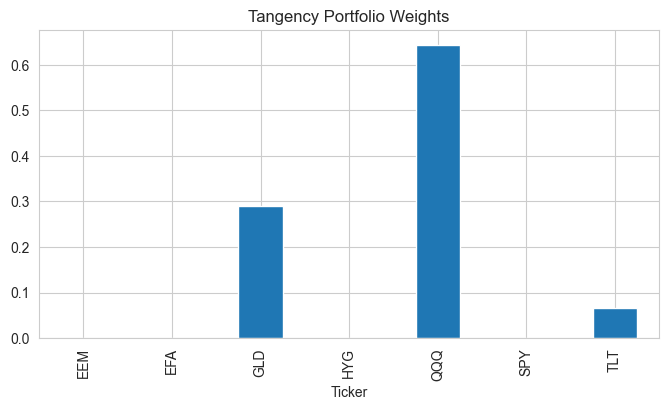

In [30]:
w_tan.plot(kind="bar", title="Tangency Portfolio Weights")
plt.show()

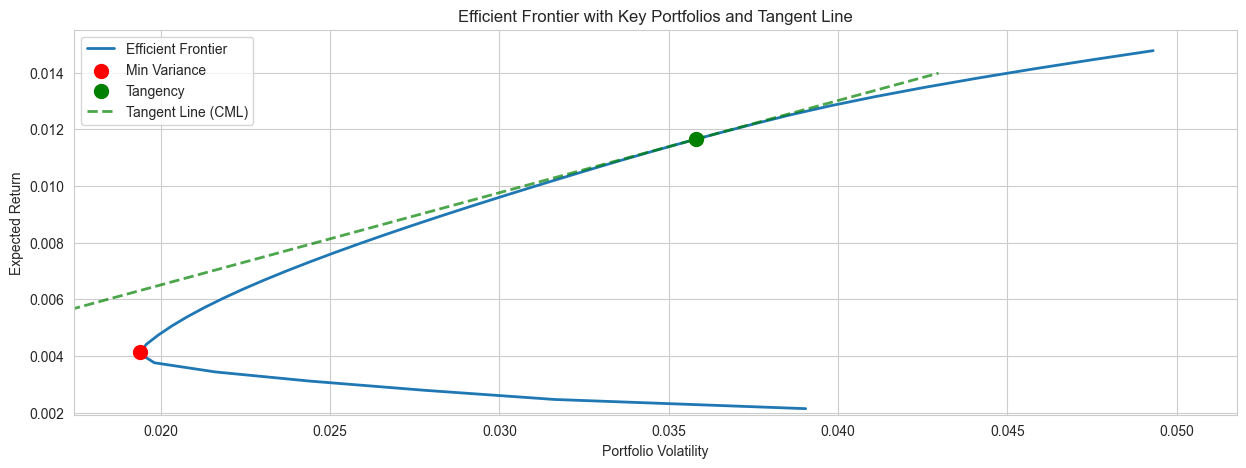

In [36]:
vol_tan = np.sqrt(w_tan.T @ Sigma @ w_tan)
ret_tan = w_tan @ mu

plt.figure(figsize=(15, 5))
plt.plot(frontier_vol, frontier_ret, label="Efficient Frontier", linewidth=2)

plt.scatter(
    np.sqrt(w_minvar.T @ Sigma @ w_minvar),
    w_minvar @ mu,
    color="red",
    s=100,
    label="Min Variance",
    zorder=5
)
plt.scatter(
    vol_tan,
    ret_tan,
    color="green",
    s=100,
    label="Tangency",
    zorder=5
)

min_vol = min(frontier_vol)
x_line = np.linspace(0, vol_tan * 1.2, 100)
y_line = (ret_tan / vol_tan) * x_line  # Slope = Sharpe ratio
plt.plot(x_line, y_line, 'g--', linewidth=2, label="Tangent Line (CML)", alpha=0.7)

plt.xlim(min_vol * 0.9, max(frontier_vol) * 1.05)
plt.ylim(min(frontier_ret) * 0.9, max(frontier_ret) * 1.05)

plt.xlabel("Portfolio Volatility")
plt.ylabel("Expected Return")
plt.legend()
plt.title("Efficient Frontier with Key Portfolios and Tangent Line")
plt.show()

- Optimal portfolios are often highly concentrated.
- Small changes in μ can dramatically alter allocations.
- This fragility is intrinsic to the framework.

# Conclusion

Mean–variance optimization is theoretically elegant but practically fragile, as noisy return estimates lead to unstable and unreliable allocations.
In practice, this sensitivity motivates the use of regularization, risk-based objectives, and robust estimators rather than direct return forecasts.
Markowitz remains a foundational benchmark, but modern portfolio methods are largely designed to address its structural weaknesses.